# Covid 19 Diagnosis using Image Classification Techniques.

### 1. Problem

* This last year has been a strange one in our world. It seems the entire world is coming together to try and tackle the COVID 19 outbreak. It has been the biggest pandemic to rock the world since the Spanish flu ended in 1920. 

* The aim of this project is to demonstrate that this dataset is useful for developing AI-based diagnosis models of COVID-19. Using this dataset, I aim to  develop diagnosis methods based on multi-task learning and self-supervised learning.

### 2. The Data

* During the outbreak time of COVID-19, computed tomography (CT) is a useful manner for diagnosing COVID-19 patients.  Due to privacy issues, publicly available COVID-19 CT datasets are highly difficult to obtain, which hinders the research and development of AI-powered diagnosis methods of COVID-19 based on CTs. 

* This open-sourced dataset -- COVID-CT,  contains 349 COVID-19 CT images from 216 patients and 463 non-COVID-19 CTs. The utility of this dataset is confirmed by a senior radiologist who has been diagnosing and treating COVID-19 patients since the outbreak of this pandemic. 

* The data and code are available at here : https://github.com/UCSD-AI4H/COVID-CT 

* The utility of this dataset has been confirmed by a senior radiologist in Tongji Hospital, Wuhan, China, who has performed diagnosis and treatment of a large number of COVID-19 patients during the outbreak of this disease between January and April.

### 3. Evaluation

* For this project , I will evaluate my model with F1-score.
I am doing this simply because it is far more important to ensure that False Negatives and False Positives are taken in to account of importance.

* For example , Let's say my model will produce an accuracy in this case = 90% which is a high enough number for the model to be considered as ‘accurate’. However, there are 5 patients who actually have Covid-19 and the model predicted that they don’t have it. Obviously, this is too high a cost. I want my model should try to minimize these False Negatives. This is why I will use F1 score.

* `F1-score :` This is the harmonic mean of Precision and Recall and gives a better measure of the incorrectly classified cases than the Accuracy Metric.

* In the original report , the study gained an an F1 of 0.85 and an AUC of 0.94 in diagnosing COVID-19 from CT scans. In this notebook , I will try to better match this or even beat this performance.

### 4. Features

* In this project I am dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.

* This is is a binary classification problem, either positive or negative in each case.

* There are around 320 positive COVID-19 images in the training set (with or without labels).

* There are around 141 negative COVID-19 images in the training set (with or without labels)




## Getting the Data and Environment Ready

In [597]:
#Importing base libraries for data exploration and analyis
import pandas as pd
import numpy as np
import json

#visualizations
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots

#For plotting some of the images
from PIL import Image

#Import OS & Datetime
import os
import datetime

# Importing Tensorflow .

import tensorflow as tf
print("TF Version : ", tf.__version__)

from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential

#For preprocessing data 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

#Import TensorFlow Hub (This is where we pick model from)
import tensorflow_hub as hub
print("TensorFlow Hub Version : ", hub.__version__)

TF Version :  2.4.0
TensorFlow Hub Version :  0.11.0


In [598]:
#Establishing file baths e.g image file path
images_directory = "/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Images/All Images/"

In [599]:
#Read in the training sets

#Negative Cases
train_df_Neg = pd.read_csv('/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Data-split/NonCOVID/trainCT_NonCOVID.csv' , names=['image_id'])
train_df_Neg['label'] = "False"

#Positive Cases
train_df_Pos = pd.read_csv('/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Data-split/COVID/trainCT_COVID.csv', names=['image_id'])
train_df_Pos['label'] = "True"

df_train = pd.concat([train_df_Neg,train_df_Pos])
df_train.head()

,image_id,label
0,14.png,False
1,15.png,False
2,33.png,False
3,43.png,False
4,44.png,False


In [600]:
#Read in the validation sets

#Negative Cases
val_df_Neg = pd.read_csv('/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Data-split/NonCOVID/valCT_NonCOVID.csv' , names=['image_id'])
val_df_Neg['label'] = "False"

#Positive Cases
val_df_Pos = pd.read_csv('/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Data-split/COVID/valCT_COVID.csv', names=['image_id'])
val_df_Pos['label'] = "True"

df_val = pd.concat([val_df_Neg,val_df_Pos])
df_val.head()

,image_id,label
0,23.png,False
1,24.png,False
2,25.png,False
3,26.png,False
4,412.png,False


In [601]:
#Read in the Test sets

test_df_Neg = pd.read_csv('/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Data-split/NonCOVID/testCT_NonCOVID.csv' , names=['image_id'])
test_df_Neg['label'] = "False"

test_df_Pos = pd.read_csv('/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Data-split/COVID/testCT_COVID.csv' , names=['image_id'])
test_df_Pos['label'] = "True"

test_df= pd.concat([test_df_Neg,test_df_Pos])
test_df = shuffle(test_df)

In [602]:
test_df.head()

,image_id,label
66,14%2.jpg,False
70,Ni2020_Article_CombinationOfWesternMedicineAn-...,True
39,1497.png,False
49,Comparison-of-different-samples-for-2019-novel...,True
30,2020.03.26.20041426-p11-133.png,True


In [603]:
#Combine the Training and Validation Datasets & Shuffle up the data
df = pd.concat([df_train,df_val])
df = shuffle(df)
df.head()

,image_id,label
43,29%0.jpg,False
5,2020.03.13.20035212-p23-160.png,True
56,2020.03.22.20040782-p24-1533-6.png,True
214,82%1.jpg,False
40,2020.03.21.20040691-p18-67-3.png,True


## Exploring the data

In [604]:
image_id = df['image_id'].values #Turn these in two arrays
image_label = df['label'].values

#Initial inspection of training dataframe

print("Training dataframe inspection \n"),
print(df.head(5)),
print(f" \n The length of image_id column {len(image_id)}"),
print(f" The length of label column {len(image_label)}")
print(f"\n The shape of training dataframe {df.shape}")

Training dataframe inspection 

                               image_id  label
43                             29%0.jpg  False
5       2020.03.13.20035212-p23-160.png   True
56   2020.03.22.20040782-p24-1533-6.png   True
214                            82%1.jpg  False
40     2020.03.21.20040691-p18-67-3.png   True
 
 The length of image_id column 543
 The length of label column 543

 The shape of training dataframe (543, 2)


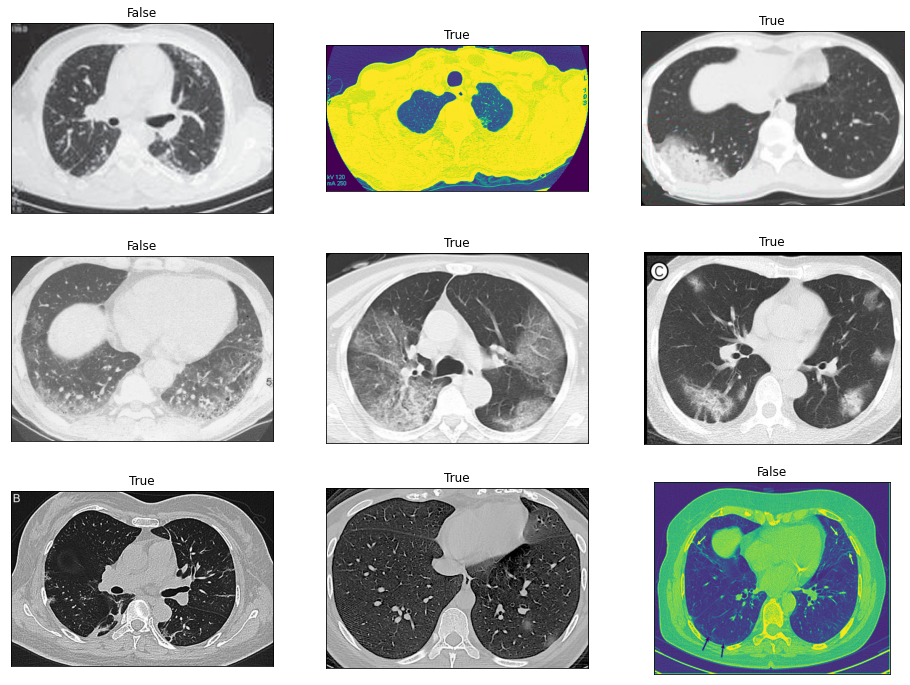

In [605]:
# Plot some of the images from the training images folder

plt.figure(figsize=(16, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = Image.open(images_directory + df.iloc[i]['image_id'])
    array = np.array(image)
    plt.imshow(array)
    label=df.iloc[i]['label']
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
plt.show()

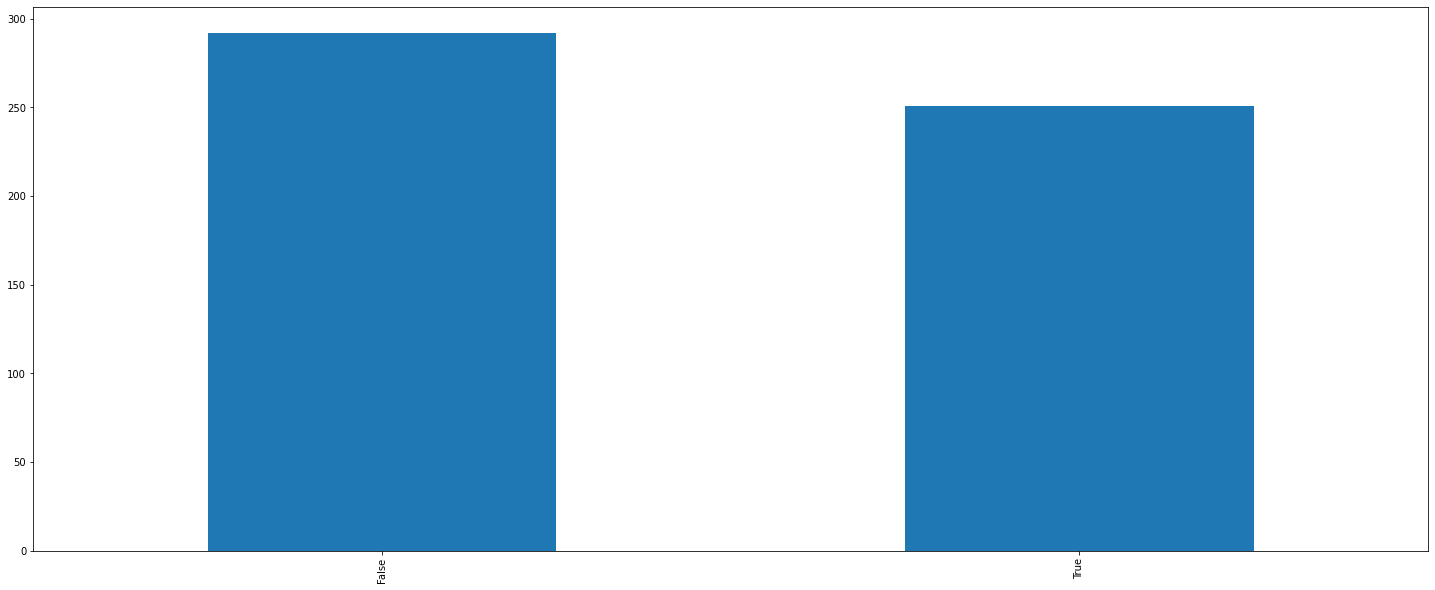

In [606]:
# How many images are there of each label (Diagnosis) ?

df['label'].value_counts().plot.bar(figsize=(25,10));

From the above , It is clear that the dataset is quite balanced in terms of Negative and Positive diagnosis. There is slightly more negative diagnosies than there are positive.

In [607]:
## To do : Print the mean and median of True/positive diagnosis & Also the same for Negative Diagnosis

labels = df.label.to_numpy()
unique_labels = np.unique(labels)
unique_labels, len(unique_labels)

(array(['False', 'True'], dtype=object), 2)

## Addressing the slight class imbalance 

Using class weights, I can offset the class imbalance in this case

In [608]:
current_balance = df['label'].value_counts(normalize=True)
current_balance

False    0.537753
True     0.462247
Name: label, dtype: float64

In [609]:
class_weight = {0: (1 - current_balance['False']) / (1 - current_balance.min()),
                1: (1 - current_balance['True']) / (1 - current_balance.min())}

class_weight

{0: 0.8595890410958905, 1: 1.0}

## Image Pre-processing

In [610]:
batch_size = 32
img_height = 224
img_width = 224

In [611]:
datagen = ImageDataGenerator(validation_split=0.2,
                             vertical_flip=True,
                             horizontal_flip=True,
                             rescale = 1./255)

def Preprocess_images(test_set=False):

    print("Creating training set data batches")
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory=images_directory,
        x_col='image_id',
        y_col='label',
        target_size=(img_width, img_height),
        batch_size=32,
        subset='training',
        seed=42)

    print("Creating validation set data batches")
    valid_datagen_flow = datagen.flow_from_dataframe(
      dataframe=df,
      directory=images_directory,
      x_col='image_id',
      y_col='label',
      target_size=(img_width, img_height),
      batch_size=32,
      subset='validation',
      seed=42)
    
    
    return train_datagen_flow , valid_datagen_flow 


In [612]:
 train_datagen_flow , valid_datagen_flow  = Preprocess_images()

Creating training set data batches
Found 435 validated image filenames belonging to 2 classes.
Creating validation set data batches
Found 108 validated image filenames belonging to 2 classes.


## Build a Model

In [613]:
df.label.value_counts()

False    292
True     251
Name: label, dtype: int64

In [614]:
#Setup input shape to the model
INPUT_SHAPE = [None , img_height, img_width , 3] # batch, height, width, colour channels

#now the output shape

OUTPUT_SHAPE = len(unique_labels) #Two possible outcomes (binary classification) -> That being True (Positive) or False (Negative)

#Setup model URL from TensorFlow Hub

#https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4 -> Works best
#https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2
#https://tfhub.dev/google/efficientnet/b7/classification/1
#https://tfhub.dev/google/tf2-preview/inception_v3/classification/4
#https://tfhub.dev/google/imagenet/nasnet_mobile/classification/4

MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

In [615]:
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    hub.KerasLayer(MODEL_URL),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                      activation= "sigmoid") #Layer 2 : Output Layer ( want this to be the length of unqiue labeled data)
  ])

In [616]:
model.compile(
      loss=tf.keras.losses.BinaryCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

In [617]:
model.build(input_shape=INPUT_SHAPE)

In [618]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_21 (KerasLayer)  (None, 1001)              5432713   
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 2004      
Total params: 5,434,717
Trainable params: 2,004
Non-trainable params: 5,432,713
_________________________________________________________________


## Create Callback

* Early Stopping Callback to prevent overfitting

* Tensorboard Callback

In [619]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

In [620]:
#Load TensorBoard notebook extension
%reload_ext tensorboard

import datetime

#Create a function to build TensorBoard callback.

def create_tensorboard_callback():
  #create a log directory for storing TensorBoard logs.
  logdir = os.path.join("/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/logs",
                        #make it so that the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)


tensorboard = create_tensorboard_callback()

## Fitting the model to Training and Validation data

In [621]:
model.fit(train_datagen_flow,
           validation_data=valid_datagen_flow, 
           epochs=50,
           callbacks=[early_stopping, tensorboard],
           class_weight=class_weight,
           verbose=2)

Epoch 1/50
14/14 - 8s - loss: 0.7742 - accuracy: 0.5379 - val_loss: 0.7458 - val_accuracy: 0.6296
Epoch 2/50
14/14 - 3s - loss: 0.5840 - accuracy: 0.6897 - val_loss: 0.7209 - val_accuracy: 0.6019
Epoch 3/50
14/14 - 3s - loss: 0.4904 - accuracy: 0.7655 - val_loss: 0.6147 - val_accuracy: 0.6759
Epoch 4/50
14/14 - 3s - loss: 0.4584 - accuracy: 0.7747 - val_loss: 0.5748 - val_accuracy: 0.7315
Epoch 5/50
14/14 - 3s - loss: 0.4334 - accuracy: 0.7862 - val_loss: 0.6619 - val_accuracy: 0.6667
Epoch 6/50
14/14 - 3s - loss: 0.3981 - accuracy: 0.7977 - val_loss: 0.5951 - val_accuracy: 0.7315
Epoch 7/50
14/14 - 3s - loss: 0.3789 - accuracy: 0.8437 - val_loss: 0.5588 - val_accuracy: 0.7407
Epoch 8/50
14/14 - 3s - loss: 0.3692 - accuracy: 0.8276 - val_loss: 0.5785 - val_accuracy: 0.7870
Epoch 9/50
14/14 - 3s - loss: 0.3460 - accuracy: 0.8391 - val_loss: 0.5582 - val_accuracy: 0.7778
Epoch 10/50
14/14 - 3s - loss: 0.3209 - accuracy: 0.8782 - val_loss: 0.5337 - val_accuracy: 0.7593
Epoch 11/50
14/14 -

## Evaluate the model on Test Data

Looks like the model can perform quite well in terms of accuracy.
The best accuracy being reported was during Epoch 12 with a val_accuracy: 0.8056 i.e Approx 81% accuracy).

As mentioned before I will be using F1 score to fully evaluate this model.



## Preprocess the test data 

As the test images are within the general image path for all images , I wanted to create a list of test file names including the path.

From these paths , I will then create a function that will allow me to pre_process the image in order to run the model on the images.

To preprcess the images in to tensors , I will create a function which wil do the below :

1. Take an image filepath as input
2. Use TensorFlow to read the file and sace it to a variable `image`
3. Turn `image` (a jpg) into Tensor
4. Resize the `image`to be a shape of (224,224) i.e a square shape
5. Return the modified `image`

Resources : 

https://www.tensorflow.org/tutorials/load_data/images

https://www.tensorflow.org/guide/data


In [622]:
#Define test images filepaths
test_filenames = [ images_directory + fname  for fname in test_df['image_id']]
test_filenames[:10]

['/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Images/All Images/14%2.jpg',
 '/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Images/All Images/Ni2020_Article_CombinationOfWesternMedicineAn-p3-10%0.png',
 '/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Images/All Images/1497.png',
 '/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Images/All Images/Comparison-of-different-samples-for-2019-novel-cor_2020_International-Journa-p2-21%3.png',
 '/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Images/All Images/2020.03.26.20041426-p11-133.png',
 '/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Images/All Images/PIIS0140673620302117_2.png',
 '/content/drive/MyDrive/Machine Learnning Projects/TensorFlow learning/Covid Detection/Images/All Images/7.jpg',
 '/content/dri

In [623]:
#Create a function for preprocessing images

def process_image(image_path):

  """
This function will take an image file path and then turn that image in to a Tensor.
  """

  #Read in an image file
  image = tf.io.read_file(image_path)

  # Turn the image in to numerical tensor with 3 colour channels
  image = tf.image.decode_jpeg(image,channels=3)

  #convert the colour channel values from 0-255 to 0-1 values (Normalization from resources above)
  image = tf.image.convert_image_dtype(image,tf.float32)

  #Resize the image
  image = tf.image.resize(image,size=[img_height,img_width])

  #Return the image
  return image

Turn the test data in to batches 

In [624]:
BATCH_SIZE = 32

#Create a function to turn data in to batches

def create_data_batches(X,y=None,batch_size=BATCH_SIZE , test_data=False):
  """
  Create batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it is training data but does not shuffle if it is validation data.
  Also accepts test data as input (no labels).
  """
  #If test dataset , we dont have labels

  if test_data:
    print("Creating test data batches")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) #only file paths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  else:
    pass

In [625]:
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches


## Predict on test data

Now that the test data is in batches and is preprocessed in to tensors and size it is time to finally predict on test the test data

In [626]:
# Make predictions on test data batch using the loaded full model
test_predictions = model.predict(test_data)

In [627]:
#first prediction
index=0
print(test_predictions[0])
print(f"Max value (probablity of predction): {np.max(test_predictions[index])}")
print(f"Sum:{np.sum(test_predictions[index])}")
print(f"Max index: {np.argmax(test_predictions[index])}")
print(f"Predictions label: {unique_labels[np.argmax(test_predictions[index])]}")

[0.71536475 0.36330873]
Max value (probablity of predction): 0.7153647541999817
Sum:1.0786734819412231
Max index: 0
Predictions label: False


In [628]:
#Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(test_predictions[0])
pred_label

'False'

In [629]:
#Lets test this
print(f"This is the ground truth label : {get_pred_label(test_df.label[0])}")
print(f"This is the predictions label : {get_pred_label(test_predictions[0])}")

This is the ground truth label : True
This is the predictions label : False


In [630]:
#Now to do it for the entire predictions list
pred_labels =[]

for pred in test_predictions:
 pred_labels.append(get_pred_label(pred))

In [631]:
#View first 5
pred_labels[:5]

['False', 'True', 'False', 'False', 'True']

In [632]:
test_df['Model Predictions'] = pred_labels

In [633]:
test_df.head()

,image_id,label,Model Predictions
66,14%2.jpg,False,False
70,Ni2020_Article_CombinationOfWesternMedicineAn-...,True,True
39,1497.png,False,False
49,Comparison-of-different-samples-for-2019-novel...,True,False
30,2020.03.26.20041426-p11-133.png,True,True


## Evaluating the test data with Sklearn Classification Report.

In [634]:

from sklearn.metrics import classification_report
y_true = test_df.label
y_pred = test_df['Model Predictions']
target_names = ['Negative Predictions', 'Positive Predictions']
print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

Negative Predictions       0.75      0.90      0.82       105
Positive Predictions       0.87      0.68      0.77        98

            accuracy                           0.80       203
           macro avg       0.81      0.79      0.79       203
        weighted avg       0.81      0.80      0.80       203



We can see the F1 scores above for borth Positive and Negative Covid predictions on the test images. 

While it is not as optimal as the initial papers results , it is something to improve upon if I was to continue with more analysis of this issue.

* For correct covid negative predictions , the model achieved an F1 score of 82%.
* For correct covid positive predictions , the model achieved an F1 score of 77%.

This resulting in an average F1 score of 79%.

Not bad considering it is a quick tensorflow hub pre-built model.